In [40]:
"""
HW3
Question 4 Factor Analsys.
@author: Vlad, Rahul
"""

%matplotlib inline
from matplotlib.pylab import plt
import os,sys
import numpy as np
from sklearn import decomposition  
#you can only use sklearn to test/debug your own implementation of FactorAnalysis

## Factor Analysis on self-reported personality data
Reference: http://web.stanford.edu/class/psych253/tutorials/FactorAnalysis.html


In [41]:
if not os.path.exists('personality0.txt'):
    ret = os.system('wget http://web.stanford.edu/class/psych253/data/personality0.txt .')
    if ret!=0:
        ret = os.system('curl -o personality0.txt http://web.stanford.edu/class/psych253/data/personality0.txt')
        if ret!=0:
            assert False,'Please download http://web.stanford.edu/class/psych253/data/personality0.txt'
print ('File: ',os.path.exists('personality0.txt'))

File:  True


In [42]:
with open('personality0.txt') as f:
    headers = [k.strip().replace('"','') for k in f.readline().split(' ')]
print ('Headers: ',headers,len(headers))
data = np.loadtxt('personality0.txt',usecols=range(1,len(headers)+1),skiprows=1)
assert data.shape==(240,len(headers))

Headers:  ['distant', 'talkatv', 'carelss', 'hardwrk', 'anxious', 'agreebl', 'tense', 'kind', 'opposng', 'relaxed', 'disorgn', 'outgoin', 'approvn', 'shy', 'discipl', 'harsh', 'persevr', 'friendl', 'worryin', 'respnsi', 'contrar', 'sociabl', 'lazy', 'coopera', 'quiet', 'organiz', 'criticl', 'lax', 'laidbck', 'withdrw', 'givinup', 'easygon'] 32


In [43]:
%%latex
$\textbf{Visualize the Correlations}: $
$\text{Cor}(X_i,Y_j) = \frac{\text{Cov}(X_i,Y_j)}{\sigma_{X_i}\sigma_{Y_j}}$

<IPython.core.display.Latex object>

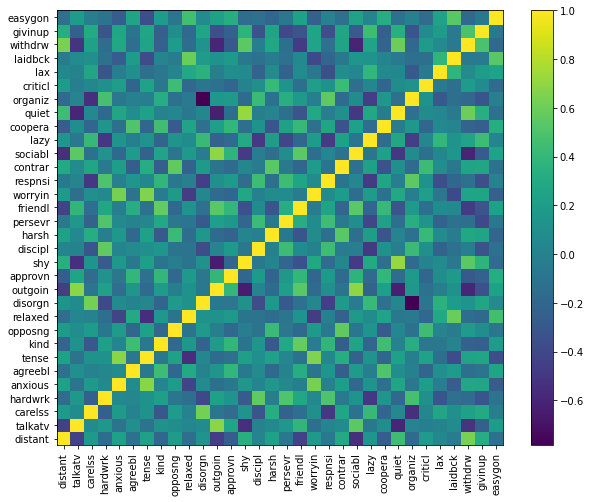

In [44]:
R = np.corrcoef(data.T)
plt.figure(figsize=(10,8))
plt.pcolor(R)
plt.colorbar()
plt.xlim([0,len(headers)])
plt.ylim([0,len(headers)])
plt.xticks(np.arange(32)+0.5,np.array(headers),rotation='vertical')
plt.yticks(np.arange(32)+0.5,np.array(headers))
plt.show()

In [58]:
#construct a function implementing the factor analysis which returns a vector of n_components largest 
# variances and the corresponding components (as column vectors in a matrix).
def FactorAnalysis(data, n_components) :
    # sample covariance
    data_centered=data-data.mean(axis=0)
    v_hat = np.cov(data_centered.T)
    # eignen-decomposition
    eigval, eigvec = np.linalg.eig(v_hat)
    # sort the eigval and find J largest ones
    idx = np.argsort(eigval)
    idx = idx[::-1]
    idx = idx[:n_components]
    V = eigvec[:,idx]
    v = eigval[idx]
    # minus sign is added 
    fa_comp = -np.matmul(V, np.diag(np.sqrt(v)))
    # compute beta
    betaI = v_hat-np.matmul(fa_comp, fa_comp.T)
    beta = np.trace(betaI).mean()
    # data transform, I learned this part from the source code of sklearn, which is based on David Barber's book
    # Bayesian Reasoning and Machine Learning
    Id = np.eye(len(fa_comp.T))
    V_psi = fa_comp/beta
    cov = np.linalg.inv(Id+np.matmul(V_psi.T, fa_comp))
    data_fa = np.matmul(data_centered, V_psi)
    data_fa = np.matmul(data_fa, cov)
    return data_fa, v, fa_comp

In [59]:
#Lets fit both the models using PCA/FA down to two dimensions. 

 
# You can check your work by using decomposition.FactorAnalysis from sklearn

n_components = 2
U, s, V = np.linalg.svd(data-data.mean(axis=0))
pca_comp =  V[range(n_components),:].T
data_pca  = U [:,range(n_components)]
data_fa, v, fa_comp = FactorAnalysis(data,n_components)



In [49]:
# FA from sklearn, we will compare this with ours
fa_sk  = decomposition.FactorAnalysis(n_components=n_components, max_iter=20)
fa_sk.fit(data)
data_fa_sk  = fa_sk.transform(data)
fa_sk_comp     = fa_sk.components_.T

In [50]:
N = 10
def plot_scatter_annotate(data,labels,title):
    plt.figure(figsize=(10,10))
    assert data.shape[0]==len(labels),'size mismatch'
    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(
        data[:, 0], data[:, 1], marker = 'o', s = 100,
        cmap = plt.get_cmap('Spectral'))
    plt.title(title)
    for label, x, y in zip(labels, data[:, 0], data[:, 1]):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.show()

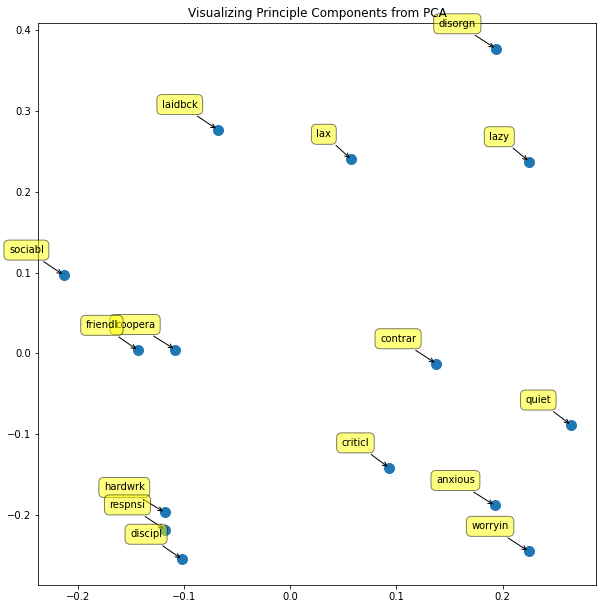

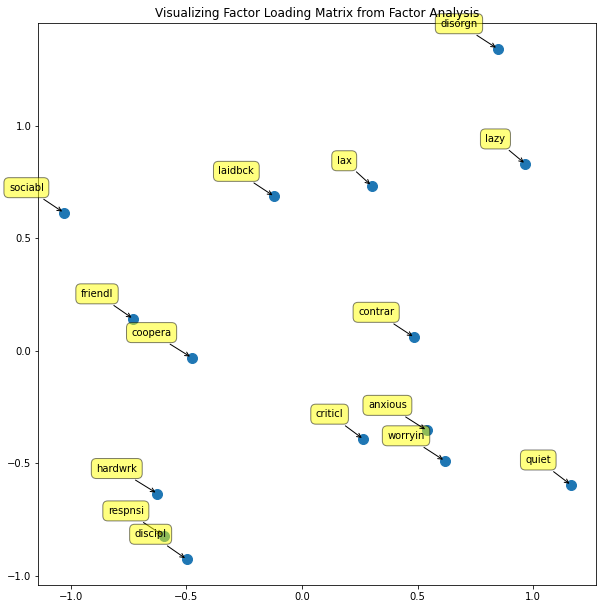

In [52]:
# compare PCA with sklearn FA 
np.random.seed(1)
idxlist = np.random.permutation(len(headers))[:15]
dset_pca = pca_comp[idxlist]
dset_fa = fa_sk_comp[idxlist]
hdr_sub = [headers[k] for k in idxlist.tolist()]
plot_scatter_annotate(dset_pca,hdr_sub,'Visualizing Principle Components from PCA')
plot_scatter_annotate(dset_fa,hdr_sub,'Visualizing Factor Loading Matrix from Factor Analysis')

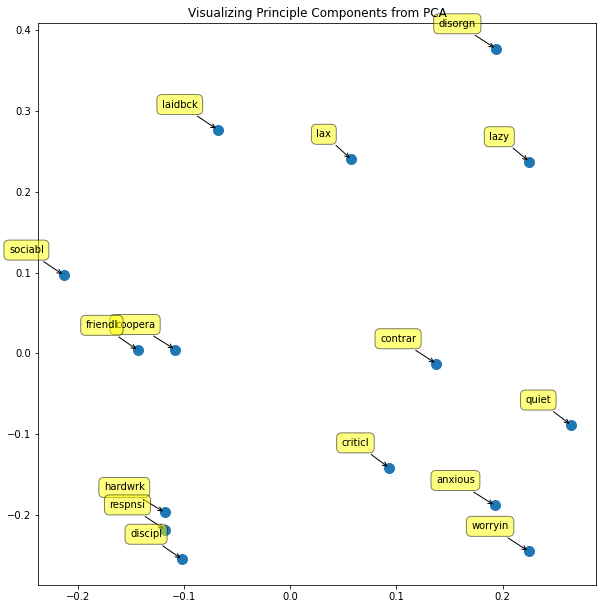

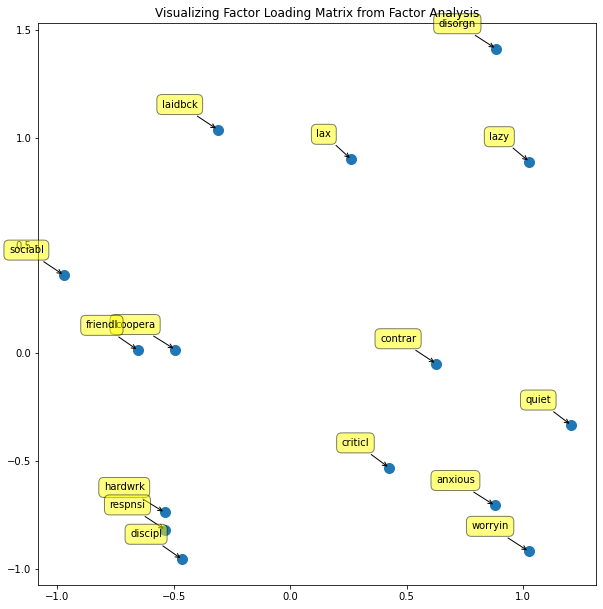

In [53]:
# compare PCA with our FA
np.random.seed(1)
idxlist = np.random.permutation(len(headers))[:15]
dset_pca = pca_comp[idxlist]
dset_fa = fa_comp[idxlist]
hdr_sub = [headers[k] for k in idxlist.tolist()]
plot_scatter_annotate(dset_pca,hdr_sub,'Visualizing Principle Components from PCA')
plot_scatter_annotate(dset_fa,hdr_sub,'Visualizing Factor Loading Matrix from Factor Analysis')

## Discussion
From the above plots, we claim that our FA has also done the job, and more importantly, it returns the same result as PCA does, up to a scaling constant (run the following code for seeing the ratio). This is because we assume noise components are of equal variance, hence FA can be viwed as PCA. On the hand, for FA from sklearn, where the equal variance is no longer assumed, we get a different result, as you can see from the polts that the patterns regarding 'friendly' and 'coopera' are shown differently in two FA plots.

In [67]:
pca_comp/fa_comp

array([[0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.21921299, 0.26714861],
       [0.